## Data Science Hands-On Problem: Loan Default Prediction

## Step 1: Import Libraries

Import the necessary libraries for:

- **pandas, numpy**: For data loading and manipulation.
- **matplotlib, seaborn**: For visualizing data trends and patterns.
- **scikit-learn**: For preprocessing, model training, evaluation, and cross-validation.
- **xgboost**: For using the XGBoost classifier, a powerful ensemble model.
- **warnings**: To suppress warning messages during execution.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## Step 2: Load and Merge Data

Load the datasets (`payment_default.csv` and `payment_history.csv`) and merge them to create a comprehensive dataset for further analysis.

Validate the input data to ensure that all required columns are present and correctly formatted before proceeding.

In [10]:
# Load datasets
try:
    payment_df = pd.read_csv('payment_default.csv')
    history_df = pd.read_csv('payment_history.csv')
except FileNotFoundError:
    raise ValueError("Input file(s) not found. Please check the file paths.")

# Validate required columns
required_payment_cols = ['client_id', 'credit_given', 'gender', 'education', 'marital_status', 'default']
required_history_cols = ['client_id', 'payment_status', 'bill_amt', 'paid_amt', 'month']
if not all(col in payment_df.columns for col in required_payment_cols):
    raise ValueError("Payment file missing required columns: " + str(required_payment_cols))
if not all(col in history_df.columns for col in required_history_cols):
    raise ValueError("History file missing required columns: " + str(required_history_cols))

# Display first few rows
print("Payment Default Data:")
print(payment_df.head())
print("\nPayment History Data:")
print(history_df.head())

# Aggregate payment history by client_id
history_agg = history_df.groupby('client_id').agg({
    'payment_status': ['mean', 'max', 'min', 'std'],
    'bill_amt': ['mean', 'sum', 'std'],
    'paid_amt': ['mean', 'sum', 'std'],
    'month': ['count', 'min', 'max']
}).reset_index()

# Flatten column names
history_agg.columns = ['_'.join(col).strip() for col in history_agg.columns.values]
history_agg = history_agg.rename(columns={'client_id_': 'client_id', 'month_count': 'history_months', 
                                         'month_min': 'earliest_month', 'month_max': 'latest_month'})

# Merge with payment data
merged_df = pd.merge(payment_df, history_agg, on='client_id', how='left')

print("\nMerged Data Shape:", merged_df.shape)
print(merged_df.head())

Payment Default Data:
   client_id  credit_given  gender  education  marital_status  month  default
0      25261         90000       2          2               2     10        0
1       1739         20000       2          2               2     10        1
2       6574        130000       2          2               1     10        0
3      11518        290000       2          2               2     10        0
4      27775        240000       2          2               2     10        0

Payment History Data:
   client_id  payment_status  bill_amt  paid_amt  month
0          1               2      3913         0      8
1          2              -1      2682         0      8
2          4               0     46990      2000      8
3          7               0    367965     55000      8
4          9               0     11285      3329      8

Merged Data Shape: (21455, 20)
   client_id  credit_given  gender  education  marital_status  month  default  \
0      25261         90000       2    

## Step 3: Exploratory Data Analysis (EDA)

Perform an in-depth analysis of the data by examining:

- **Distributions**: Analyze the distribution of key features.
- **Relationships**: Identify correlations between features and target variables.
- **Missing values**: Check for any missing or null values in the dataset.
- **Outliers**: Detect any outliers that could impact model performance.

This step is crucial for gaining insights into the data and informing further preprocessing decisions.


Summary Statistics:
          client_id    credit_given        gender     education  \
count  21455.000000    21455.000000  21455.000000  21455.000000   
mean   14963.884549   167999.518993      1.604055      1.851270   
std     8672.625473   129807.807264      0.489064      0.788552   
min        1.000000    10000.000000      1.000000      0.000000   
25%     7409.000000    50000.000000      1.000000      1.000000   
50%    14993.000000   140000.000000      2.000000      2.000000   
75%    22458.500000   240000.000000      2.000000      2.000000   
max    29997.000000  1000000.000000      2.000000      6.000000   

       marital_status    month       default  payment_status_mean  \
count    21455.000000  21455.0  21455.000000         21455.000000   
mean         1.552785     10.0      0.223351            -0.187074   
std          0.522183      0.0      0.416502             0.983588   
min          0.000000     10.0      0.000000            -2.000000   
25%          1.000000     10.0

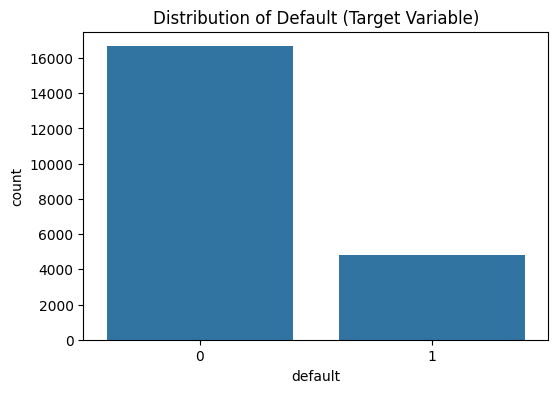

Default Rate: 0.2234


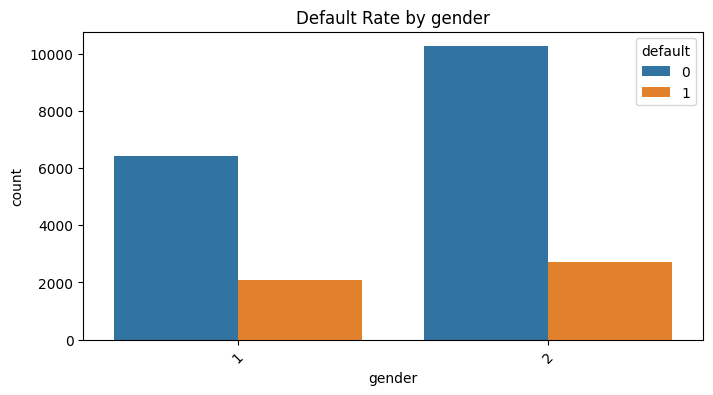

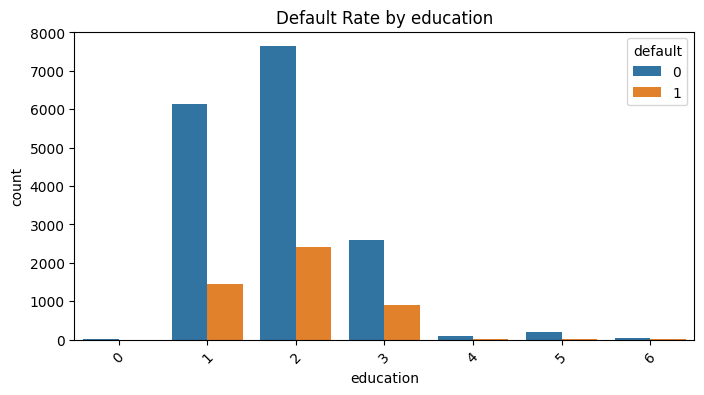

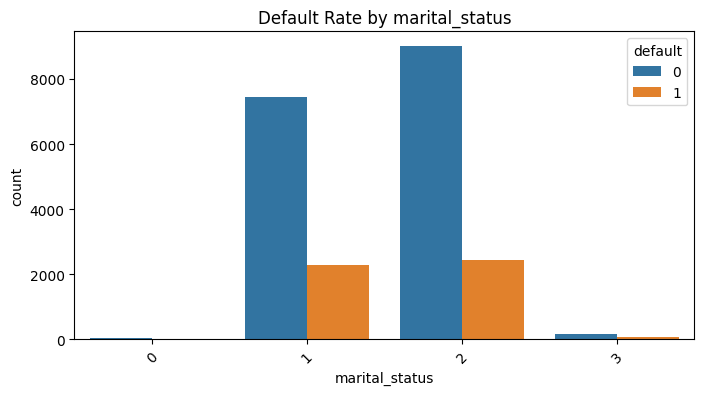

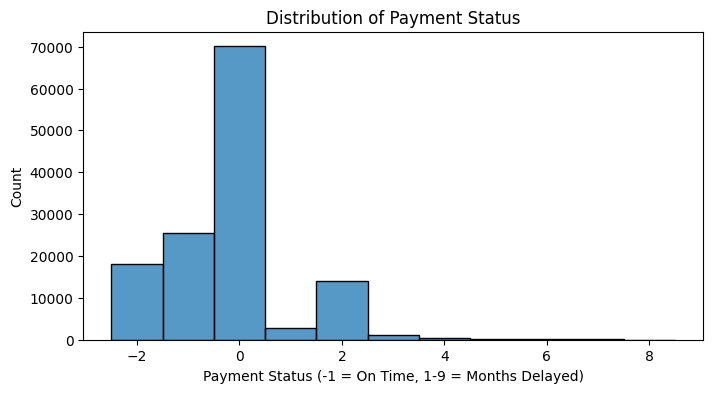

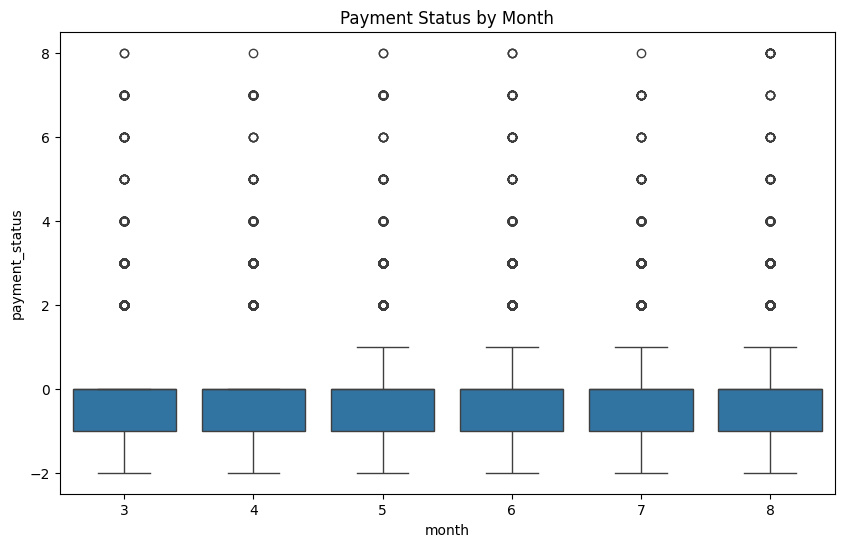

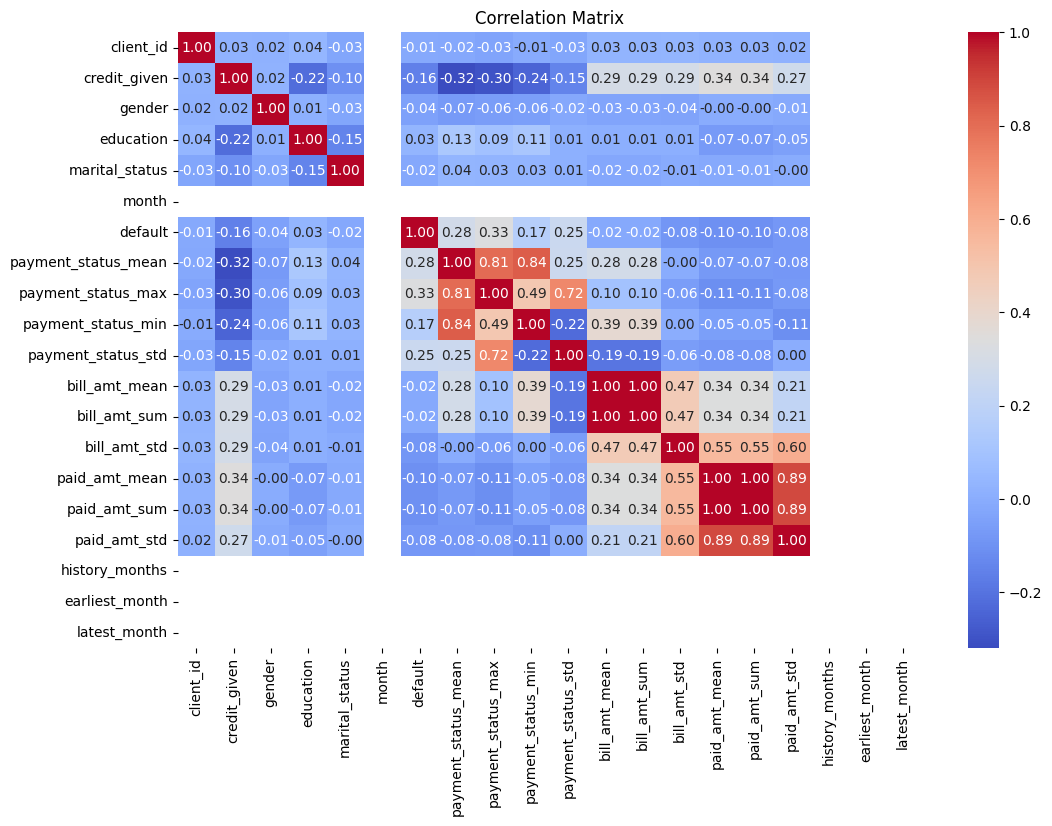

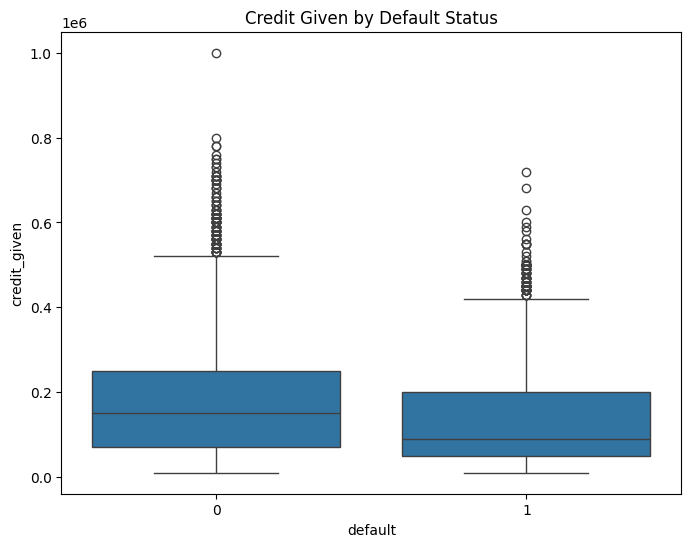

Capped credit_given at 99th percentile: 500000.0


In [11]:
# Summary statistics
print("\nSummary Statistics:")
print(merged_df.describe())

# Check for missing values
print("\nMissing Values:")
print(merged_df.isnull().sum())

# Distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='default', data=merged_df)
plt.title('Distribution of Default (Target Variable)')
plt.show()
default_rate = merged_df['default'].mean()
print(f"Default Rate: {default_rate:.4f}")

# Categorical variable analysis
categorical_cols = ['gender', 'education', 'marital_status']
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='default', data=merged_df)
    plt.title(f'Default Rate by {col}')
    plt.xticks(rotation=45)
    plt.show()

# Payment status distribution
plt.figure(figsize=(8, 4))
sns.histplot(history_df['payment_status'], bins=range(-1, 11), discrete=True)
plt.title('Distribution of Payment Status')
plt.xlabel('Payment Status (-1 = On Time, 1-9 = Months Delayed)')
plt.show()

# Temporal analysis: Payment status by month
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='payment_status', data=history_df)
plt.title('Payment Status by Month')
plt.show()

# Correlation matrix
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 8))
sns.heatmap(merged_df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Outlier detection for credit_given
plt.figure(figsize=(8, 6))
sns.boxplot(x='default', y='credit_given', data=merged_df)
plt.title('Credit Given by Default Status')
plt.show()

# Outlier handling: Cap credit_given at 99th percentile
credit_cap = merged_df['credit_given'].quantile(0.99)
merged_df['credit_given'] = merged_df['credit_given'].clip(upper=credit_cap)
print(f"Capped credit_given at 99th percentile: {credit_cap}")

## Step 4: Data Cleaning

Handle missing values and ensure consistency across the dataset. This may include:

- Imputing or removing missing values.
- Ensuring proper data types for each column.
- Addressing any inconsistencies or duplicates.

Data cleaning is essential to ensure high-quality input for model training.

In [12]:
# Impute missing values for history-related columns with median
history_cols = [col for col in merged_df.columns if col.startswith(('payment_status', 'bill_amt', 'paid_amt', 'history_months'))]
merged_df[history_cols] = merged_df[history_cols].fillna(merged_df[history_cols].median())

# Verify no remaining missing values
print("\nMissing Values After Imputation:")
print(merged_df.isnull().sum())


Missing Values After Imputation:
client_id              0
credit_given           0
gender                 0
education              0
marital_status         0
month                  0
default                0
payment_status_mean    0
payment_status_max     0
payment_status_min     0
payment_status_std     0
bill_amt_mean          0
bill_amt_sum           0
bill_amt_std           0
paid_amt_mean          0
paid_amt_sum           0
paid_amt_std           0
history_months         0
earliest_month         0
latest_month           0
dtype: int64


## Step 5: Feature Engineering

Create new features and encode categorical variables to enhance the model's predictive power. This may include:

- Generating interaction features.
- Normalizing or scaling continuous variables.
- Encoding categorical variables using techniques like one-hot encoding or label encoding.

Feature engineering plays a crucial role in improving model performance by providing the model with meaningful and structured data.

In [13]:
# Create repayment ratio
merged_df['repayment_ratio'] = merged_df['paid_amt_sum'] / (merged_df['bill_amt_sum'] + 1e-6)  # Avoid division by zero

# Create temporal feature: months since earliest payment
merged_df['months_since_earliest'] = merged_df['latest_month'] - merged_df['earliest_month']

# Encode categorical variables
merged_df = pd.get_dummies(merged_df, columns=['gender', 'education', 'marital_status'], drop_first=True)

# Drop unnecessary columns
features_df = merged_df.drop(['client_id', 'default'], axis=1)
target = merged_df['default']

print("\nFeatures Shape:", features_df.shape)
print("Feature Columns:", features_df.columns.tolist())

# Save feature columns for scoring function
training_features = features_df.columns.tolist()


Features Shape: (21455, 27)
Feature Columns: ['credit_given', 'month', 'payment_status_mean', 'payment_status_max', 'payment_status_min', 'payment_status_std', 'bill_amt_mean', 'bill_amt_sum', 'bill_amt_std', 'paid_amt_mean', 'paid_amt_sum', 'paid_amt_std', 'history_months', 'earliest_month', 'latest_month', 'repayment_ratio', 'months_since_earliest', 'gender_2', 'education_1', 'education_2', 'education_3', 'education_4', 'education_5', 'education_6', 'marital_status_1', 'marital_status_2', 'marital_status_3']


## Step 6: Model Development

Split the data into training and testing sets, handle class imbalance, and scale the features. Then, train multiple models with cross-validation to evaluate their performance. This step involves:

- Splitting the data using `train_test_split`.
- Addressing class imbalance with techniques like **SMOTE**.
- Scaling features using methods like **StandardScaler**.
- Training and evaluating models such as **Logistic Regression**, **Random Forest**, and **XGBoost**.

Cross-validation helps ensure that the models generalize well to unseen data.

Scale Pos Weight for XGBoost: 3.4768



Logistic Regression Cross-Validation AUC: 0.7382 ± 0.0162
Logistic Regression Test Performance:
AUC: 0.7437, Precision: 0.4352, Recall: 0.6660, F1: 0.5264

Random Forest Cross-Validation AUC: 0.7511 ± 0.0070
Random Forest Test Performance:
AUC: 0.7527, Precision: 0.5748, Recall: 0.3090, F1: 0.4019

XGBoost Cross-Validation AUC: 0.7411 ± 0.0100
XGBoost Test Performance:
AUC: 0.7396, Precision: 0.4405, Recall: 0.5678, F1: 0.4961

Best Model: Random Forest
Best Threshold: 0.3, F1 Score: 0.5069
Tuned Random Forest Test AUC: 0.7527


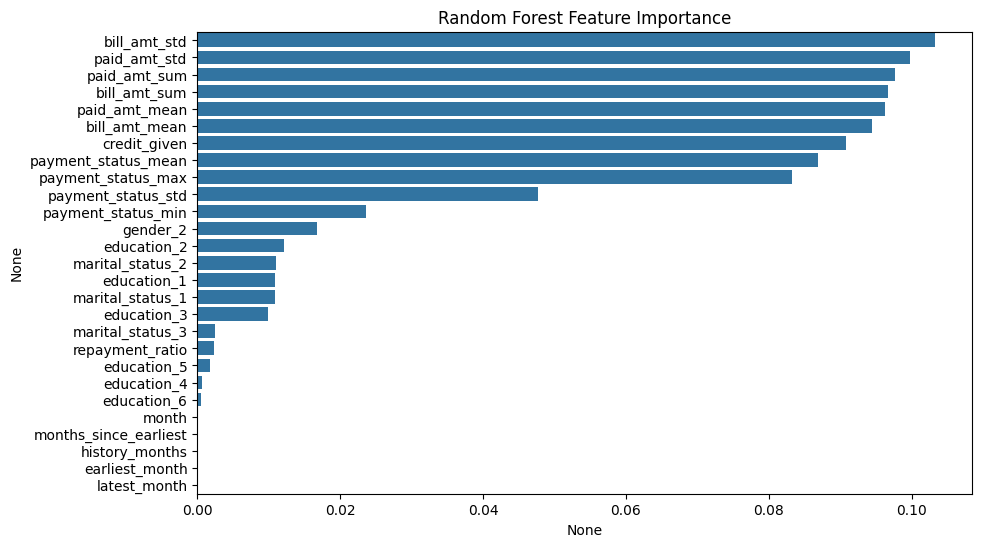

In [14]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.2, random_state=42, stratify=target)

# Calculate class weights for XGBoost
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos if pos > 0 else 1
print(f"Scale Pos Weight for XGBoost: {scale_pos_weight:.4f}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models with class weights
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
}

# Train and evaluate models with cross-validation
results = {}
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    print(f"\n{name} Cross-Validation AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    auc = roc_auc_score(y_test, y_prob)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {'AUC': auc, 'Precision': precision, 'Recall': recall, 'F1': f1}
    
    print(f"{name} Test Performance:")
    print(f"AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# Select best model (based on AUC)
best_model_name = max(results, key=lambda x: results[x]['AUC'])
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")

# Hyperparameter tuning for best model (e.g., XGBoost)
if best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1]
    }
    grid_search = GridSearchCV(XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=scale_pos_weight),
                               param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    best_model = grid_search.best_estimator_
    print("\nBest Parameters:", grid_search.best_params_)
    
    # Re-evaluate
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1]
    print(f"Tuned {best_model_name} Test AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Threshold tuning for best model
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]
thresholds = np.arange(0.3, 0.8, 0.1)
best_f1 = 0
best_threshold = 0.5
for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
print(f"Best Threshold: {best_threshold}, F1 Score: {best_f1:.4f}")

# Retrain best model and evaluate with optimal threshold
best_model.fit(X_train_scaled, y_train)
y_pred = (best_model.predict_proba(X_test_scaled)[:, 1] >= best_threshold).astype(int)
print(f"Tuned {best_model_name} Test AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Feature importance for best model (if applicable)
if best_model_name in ['Random Forest', 'XGBoost']:
    plt.figure(figsize=(10, 6))
    feature_importance = pd.Series(best_model.feature_importances_, index=training_features).sort_values(ascending=False)
    sns.barplot(x=feature_importance, y=feature_importance.index)
    plt.title(f'{best_model_name} Feature Importance')
    plt.show()

## Step 7: Scoring Function

Create a robust function to process new, unseen data and return predictions. This involves:

- Preprocessing the input data (scaling, encoding, etc.) in the same way as the training data.
- Passing the preprocessed data through the trained model to generate predictions.
- Returning the model’s output in a user-friendly format (e.g., probabilities or class labels).

The scoring function ensures that the model can make predictions on new data in a consistent and reproducible manner.

In [15]:
def score_new_data(payment_file, history_file, model, scaler, training_features, impute_strategy='median', threshold=0.5):
    """
    Process input files and return predictions.
    
    Parameters:
    - payment_file: Path to payment_default.csv
    - history_file: Path to payment_history.csv
    - model: Trained model
    - scaler: Fitted StandardScaler
    - training_features: List of feature columns from training
    - impute_strategy: 'zero', 'mean', or 'median' for missing value imputation
    - threshold: Probability threshold for default prediction
    
    Returns:
    - DataFrame with client_id, probability_of_default, and default_indicator
    """
    try:
        # Load data
        payment_df = pd.read_csv(payment_file)
        history_df = pd.read_csv(history_file)
    except FileNotFoundError:
        raise ValueError("Input file(s) not found. Please check the file paths.")
    
    # Validate required columns
    required_payment_cols = ['client_id', 'credit_given', 'gender', 'education', 'marital_status']
    required_history_cols = ['client_id', 'payment_status', 'bill_amt', 'paid_amt', 'month']
    if not all(col in payment_df.columns for col in required_payment_cols):
        raise ValueError("Payment file missing required columns: " + str(required_payment_cols))
    if not all(col in history_df.columns for col in required_history_cols):
        raise ValueError("History file missing required columns: " + str(required_history_cols))
    
    # Aggregate history
    history_agg = history_df.groupby('client_id').agg({
        'payment_status': ['mean', 'max', 'min', 'std'],
        'bill_amt': ['mean', 'sum', 'std'],
        'paid_amt': ['mean', 'sum', 'std'],
        'month': ['count', 'min', 'max']
    }).reset_index()
    history_agg.columns = ['_'.join(col).strip() for col in history_agg.columns.values]
    history_agg = history_agg.rename(columns={'client_id_': 'client_id', 'month_count': 'history_months', 
                                             'month_min': 'earliest_month', 'month_max': 'latest_month'})
    
    # Merge
    merged_df = pd.merge(payment_df, history_agg, on='client_id', how='left')
    
    # Data cleaning
    history_cols = [col for col in merged_df.columns if col.startswith(('payment_status', 'bill_amt', 'paid_amt', 'history_months'))]
    if impute_strategy == 'zero':
        merged_df[history_cols] = merged_df[history_cols].fillna(0)
    elif impute_strategy == 'mean':
        merged_df[history_cols] = merged_df[history_cols].fillna(merged_df[history_cols].mean())
    elif impute_strategy == 'median':
        merged_df[history_cols] = merged_df[history_cols].fillna(merged_df[history_cols].median())
    else:
        raise ValueError("Invalid impute_strategy. Choose 'zero', 'mean', or 'median'.")
    
    # Feature engineering
    merged_df['repayment_ratio'] = merged_df['paid_amt_sum'] / (merged_df['bill_amt_sum'] + 1e-6)
    merged_df['months_since_earliest'] = merged_df['latest_month'] - merged_df['earliest_month']
    
    # Encode categorical variables
    merged_df = pd.get_dummies(merged_df, columns=['gender', 'education', 'marital_status'], drop_first=True)
    
    # Align features with training data
    for col in training_features:
        if col not in merged_df.columns:
            merged_df[col] = 0
    merged_df = merged_df[training_features]
    
    # Scale features
    try:
        X_scaled = scaler.transform(merged_df)
    except ValueError as e:
        raise ValueError("Feature mismatch or scaling error: " + str(e))
    
    # Predict
    probabilities = model.predict_proba(X_scaled)[:, 1]
    predictions = (probabilities >= threshold).astype(int)
    
    # Create output
    output_df = pd.DataFrame({
        'client_id': payment_df['client_id'],
        'probability_of_default': probabilities,
        'default_indicator': predictions
    })
    
    return output_df

# Test scoring function
try:
    output = score_new_data('TestFiles/test_payment_default.csv', 'TestFiles/test_payment_history.csv', 
                            best_model, scaler, training_features, impute_strategy='median', threshold=best_threshold)
    print("\nScoring Function Output:")
    print(output.head())
except Exception as e:
    print(f"Error in scoring function: {e}")


Scoring Function Output:
   client_id  probability_of_default  default_indicator
0       1001                    0.32                  1
1       1002                    0.26                  0
2       1003                    0.31                  1
3       1004                    0.16                  0
4       1005                    0.33                  1


In [16]:
#Test
import pandas as pd
import joblib
from sklearn.metrics import roc_auc_score

# Load saved objects
best_model = joblib.load('best_model.pkl')
scaler = joblib.load('scaler.pkl')
training_features = joblib.load('training_features.pkl')

# Run scoring function``
try:
    output = score_new_data(
        payment_file='TestFiles/test_payment_default.csv',
        history_file='TestFiles/test_payment_history.csv',
        model=best_model,
        scaler=scaler,
        training_features=training_features,
        impute_strategy='median',
        threshold=0.5
    )
    print("Scoring Output:")
    print(output.head())
    output.to_csv('predictions.csv', index=False)
    print("Predictions saved to predictions.csv")

    # Validate if test data has ground truth
    test_df = pd.read_csv('TestFiles/test_payment_default.csv')
    if 'default' in test_df.columns:
        y_true = test_df['default']
        print("Test AUC:", roc_auc_score(y_true, output['probability_of_default']))
except Exception as e:
    print(f"Error: {e}")

Scoring Output:
   client_id  probability_of_default  default_indicator
0       1001                    0.32                  0
1       1002                    0.26                  0
2       1003                    0.31                  0
3       1004                    0.16                  0
4       1005                    0.33                  0
Predictions saved to predictions.csv
Test AUC: 0.416
